#### **Background:**

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

#### **Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**age:** age of customer (numeric)

**job:** type of job (categorical)

**marital:** marital status (categorical)

**education:** (categorical)

**default:** has credit in default? (binary)

**balance:** average yearly balance, in euros (numeric)

**housing:** has a housing loan? (binary)

**loan:** has personal loan? (binary)

**contact:** contact communication type (categorical)

**day:** last contact day of the month (numeric)

**month:** last contact month of year (categorical)

**duration:** last contact duration, in seconds (numeric)

**campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

**y:** has the client subscribed to a term deposit? (binary)

#### **Goal(s):**

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

#### **Success Metric(s):**

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

#### **Bonus(es):**

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

What makes the customers buy? Tell us which feature we should be focusing more on.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('term-deposit-marketing-2020.csv', skiprows=1, names=["age", "job", "marital", "education", "default", "balance", "housing", "loan", "contact", "day", "month", "duration", "campaign", "y"])
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [5]:
binary_features = ['default', 'housing', 'loan', 'y']
df[binary_features] = df[binary_features].apply(lambda x: x.map({'yes': 1, 'no': 0}))

label_encoder = LabelEncoder()
categorical_features = ["job", "marital", "education", "contact", "month"]

for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        40000 non-null  int64
 1   job        40000 non-null  int32
 2   marital    40000 non-null  int32
 3   education  40000 non-null  int32
 4   default    40000 non-null  int64
 5   balance    40000 non-null  int64
 6   housing    40000 non-null  int64
 7   loan       40000 non-null  int64
 8   contact    40000 non-null  int32
 9   day        40000 non-null  int64
 10  month      40000 non-null  int32
 11  duration   40000 non-null  int64
 12  campaign   40000 non-null  int64
 13  y          40000 non-null  int64
dtypes: int32(5), int64(9)
memory usage: 3.5 MB


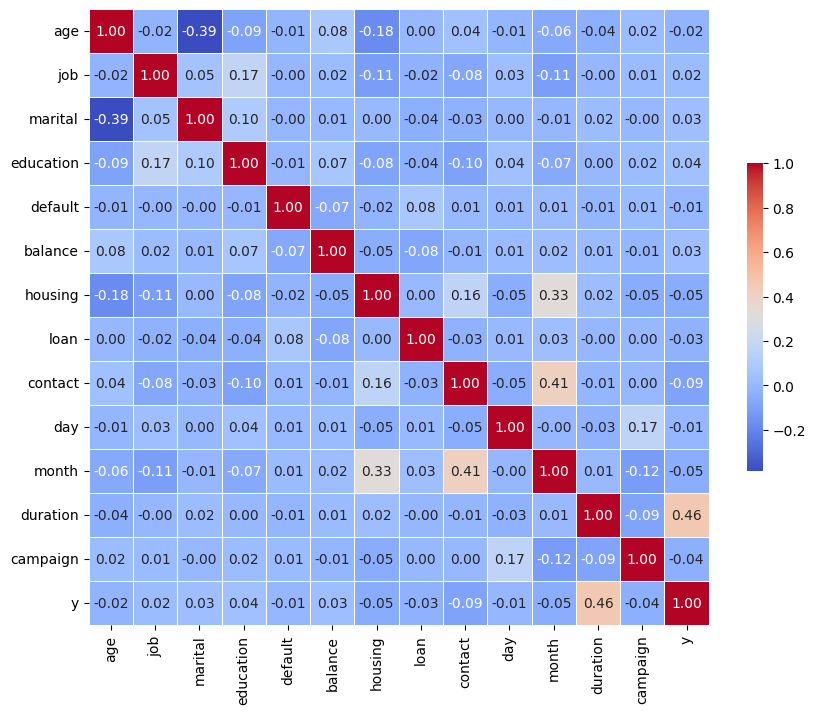

In [8]:
corr = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [9]:
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')
])

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=30, validation_split=0.2, batch_size=32)

Epoch 1/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7741 - loss: 0.4803 - val_accuracy: 0.9319 - val_loss: 0.1862
Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9261 - loss: 0.2050 - val_accuracy: 0.9320 - val_loss: 0.1806
Epoch 3/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9280 - loss: 0.1898 - val_accuracy: 0.9319 - val_loss: 0.1787
Epoch 4/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9311 - loss: 0.1826 - val_accuracy: 0.9319 - val_loss: 0.1763
Epoch 5/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9282 - loss: 0.1789 - val_accuracy: 0.9317 - val_loss: 0.1746
Epoch 6/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9274 - loss: 0.1783 - val_accuracy: 0.9314 - val_loss: 0.1740
Epoch 7/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9286 - loss: 0.1749 - val_accuracy: 0.9314 - val_loss: 0.1726
Epoch 8/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9302 - loss: 0.1748 - val_accuracy: 0.

In [13]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.9387 - loss: 0.1455
Test Loss: 0.15583625435829163
Test Accuracy: 0.9355000257492065


In [14]:
xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train_scaled, y_train)
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)
print("Train accuracy: ", accuracy_score(y_train, y_pred_train))
print("Test Classification Report:\n", classification_report(y_test, y_pred_test))

Train accuracy:  0.9759375
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7421
           1       0.61      0.43      0.51       579

    accuracy                           0.94      8000
   macro avg       0.78      0.71      0.74      8000
weighted avg       0.93      0.94      0.93      8000

